# Bias Experiments

In [2]:
import os, json
import sys
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

## State Transition

In [13]:
def fivo_gradient_sample(n_samples=100, n_particles=16, theta1=0.1, theta2=1.0, T=200,
                          std0=1., std1=1., std2=math.sqrt(0.1), seed=0):
    np.random.seed(seed)
    
    def log_prob(x, mu, sigma):
        return -0.5*(math.log(2*math.pi*sigma**2) + (x-mu)**2/sigma**2)

    def prob(x, mu, sigma):
        return np.exp(-(x-mu)**2/(2*sigma**2))/np.sqrt(2*math.pi*sigma)

    def logsumexp(x, axis=0):
        return np.log(np.sum(np.exp(x), axis=axis))
    
    # generating observation
    true_z = np.zeros((T, n_samples))
    true_z[0] = np.random.normal(0, std0, n_samples)
    for t in range(T-1):
        true_z[t+1] = theta1 * true_z[t] + np.random.normal(0, std1, n_samples)
    obs = theta2 * true_z + np.random.normal(0, std2, (T, n_samples))
    
    # inference
    grad_ZSMC1 = np.zeros(n_samples)
    grad_ZSMC2 = np.zeros(n_samples)
    grad_Cat1 = np.zeros(n_samples)
    grad_Cat2 = np.zeros(n_samples)
    z_prevs = np.zeros((T, n_particles, n_samples))
    z_fils = np.zeros((T, n_particles, n_samples))
    logws = np.zeros((T, n_particles, n_samples))
    a = np.zeros((T, n_particles, n_samples), dtype=int)
    z_prevs[0] = np.random.normal(0, std0, ( n_particles, n_samples)) #(np,ns)
    logw = log_prob(obs[0], theta2 * z_prevs[0], std2) #(np,ns)
    logws[0] = logw
    logw = logw - logsumexp(logw, axis=0)
    for i in range(n_samples):
        a[0,:,i] = np.random.choice(np.arange(n_particles), size=n_particles, p=np.exp(logw)[:,i])
        z_fils[0,:,i] = z_prevs[0,:,i][a[0,:,i]]
    for t in range(T-1):
        z_prevs[t+1] = theta1 * z_fils[t] + np.random.normal(0, std1, (n_particles, n_samples))
        logg = log_prob(obs[t+1], theta2 * z_prevs[t+1], std2) #(np,ns)
        logf = log_prob(z_prevs[t+1], theta1 * z_fils[t], std1) #(np,ns)
        logq = log_prob(z_prevs[t+1], theta1 * z_fils[t], std1) #(np,ns)
        logw = logg + logf - logq
        logws[t+1] = logw
        logw = logw - logsumexp(logw, axis=0)
        for i in range(n_samples):
            a[t+1,:,i] = np.random.choice(np.arange(n_particles), size=n_particles, p=np.exp(logw)[:,i])
            z_fils[t+1,:,i] = z_prevs[t+1,:,i][a[t+1,:,i]]
            a[:t,:,i] = a[:t,a[t+1,:,i],i]
            if t>=1:
                #grad_Cat[i] += np.sum(z_fils[t][a[t,:,i]]*(z_prevs[t+1][a[t+1,:,i]]-theta1*z_fils[t][a[t,:,i]])/std1**2)
                grad_Cat1[i] += np.sum(z_fils[t,:,i][a[t,:,i]]*(z_fils[t+1,:,i]-theta1*z_fils[t,:,i][a[t,:,i]])/std1**2)
                grad_Cat2[i] += np.sum(z_fils[t,:,i][a[t,:,i]]*(obs[t,i]-theta2*z_fils[t,:,i][a[t,:,i]])/std1**2)
        grad_ZSMC1 += np.sum(z_fils[t]*(z_prevs[t+1]-theta1*z_fils[t])*np.exp(logws[t+1])/std1**2, axis=0) \
                        / np.exp(logsumexp(logws[t+1], axis=0)) #(ns)
        grad_ZSMC2 += np.sum(z_prevs[t+1]*(obs[t+1]-theta2*z_prevs[t+1])*np.exp(logws[t+1])/std2**2, axis=0) \
                        / np.exp(logsumexp(logws[t+1], axis=0)) #(ns)
    log_ZSMC = (logsumexp(logws, axis=1) - math.log(n_particles)).sum(axis=0) #(ns)
    
    return log_ZSMC*grad_Cat1 + grad_ZSMC1, grad_ZSMC1, log_ZSMC*grad_Cat2 + grad_ZSMC2, grad_ZSMC2#, grad_Cat2, log_ZSMC

57075.78904088648
10.39228676987663
34723.404878851325
54.055354694767196


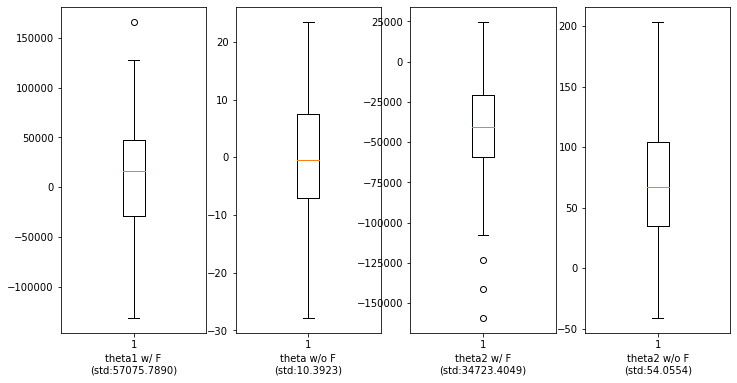

In [15]:
grads_fivo = fivo_gradient_sample(100, 16, 0.1, 1.0, seed=0)
# print(wo_grad.std(), w_grad.std())

fig, ax = plt.subplots(1,len(grads),figsize=(12,6))
name_list = ["theta1 w/ F", "theta w/o F", "theta2 w/ F", "theta2 w/o F", "grad_Cat2", "log_ZSMC"]
for i, grad in enumerate(grads_fivo):
    print(grad.std())
    ax[i].boxplot(grad)
    ax[i].set_xlabel("{}\n(std:{:.4f})".format(name_list[i], grad.std()))
fig.set_facecolor("w")

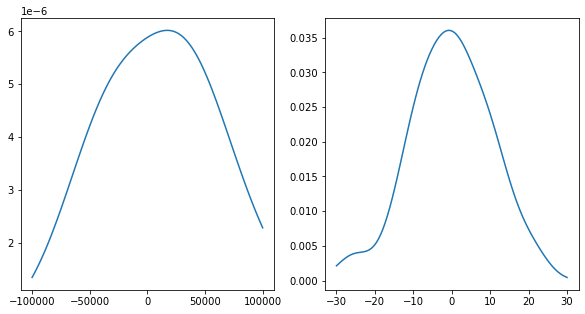

In [19]:
from sklearn.neighbors import KernelDensity
fig, ax = plt.subplots(1,2,figsize=(10,5))

woplot = np.linspace(-200000,200000,100)[:,None]
log_dens = KernelDensity(kernel='gaussian', bandwidth=30000).fit(wo_grad[:,None]).score_samples(woplot)
ax[0].plot(woplot[:,0], np.exp(log_dens))

woplot = np.linspace(-30,30,100)[:,None]
log_dens = KernelDensity(kernel='gaussian', bandwidth=4).fit(w_grad[:,None]).score_samples(woplot)
ax[1].plot(woplot[:,0], np.exp(log_dens))

In [18]:
def enko_gradient_sample(n_samples=100, n_particles=16, inflation=None, alpha=0, ftheta1=0.1, qtheta1=0.1, theta2=1.0, T=200,
                          std0=1., std1=1., std2=math.sqrt(0.1), seed=0):
    np.random.seed(seed)
    if inflation==None:
        alpha=0
    
    def log_prob(x, mu, sigma):
        return -0.5*(math.log(2*math.pi*sigma**2) + (x-mu)**2/sigma**2)

    def prob(x, mu, sigma):
        return np.exp(-(x-mu)**2/(2*sigma**2))/np.sqrt(2*math.pi*sigma)

    def logsumexp(x, axis=0):
        return np.log(np.sum(np.exp(x), axis=axis))
    
    # generating observation
    true_z = np.zeros((T, n_samples))
    true_z[0] = np.random.normal(0, std0, n_samples)
    for t in range(T-1):
        true_z[t+1] = ftheta1 * true_z[t] + np.random.normal(0, std1, n_samples)
    obs = theta2 * true_z + np.random.normal(0, std2, (T, n_samples))
    
    # inference
    grad_ZSMC1 = np.zeros(n_samples)
    grad_ZSMC2 = np.zeros(n_samples)
    grad_Cat2 = np.zeros(n_samples)
    z_prevs = np.zeros((T, n_particles, n_samples))
    x_prevs = np.zeros((T, n_particles, n_samples))
    Sigma_x = np.zeros((T, n_samples))
    Sigma_z = np.zeros((T, n_samples))
    if inflation=="RTPS":
        Sigma_zf = np.zeros((T, n_samples))
    z_fils = np.zeros((T, n_particles, n_samples))
    logws = np.zeros((T, n_particles, n_samples))
    a = np.zeros((T, n_particles, n_samples), dtype=int)
    z_prevs[0] = np.random.normal(0, std0, ( n_particles, n_samples)) #(np,ns)
    logw = log_prob(obs[0], theta2 * z_prevs[0], std2) #(np,ns)
    logws[0] = logw
    logw = logw - logsumexp(logw, axis=0)
    x_prevs[0] = theta2 * z_prevs[0] + np.random.normal(0, std2, (n_particles, n_samples)) #(np,ns)
    Sigma_x[0] = ((x_prevs[0] - x_prevs[0].mean(0))**2).mean(0) #(ns,)
    Sigma_z[0] = ((z_prevs[0] - z_prevs[0].mean(0))**2).mean(0) #(ns,)
    z_fils[0] = z_prevs[0] + theta2*Sigma_z[0]/Sigma_x[0]*(obs[0] - x_prevs[0]) #(np,ns)
    if inflation=="RTPP":
        z_fils[0] = alpha*z_prevs[0] + (1-alpha)*z_fils[0]
    elif inflation=="RTPS":
        Sigma_zf[0] = ((z_fils[0] - z_fils[0].mean(0))**2).mean(0) #(ns,)
    
    for t in range(T-1):
        z_prevs[t+1] = qtheta1 * z_fils[t] + np.random.normal(0, std1, (n_particles, n_samples))
        logg = log_prob(obs[t+1], theta2 * z_prevs[t+1], std2) #(np,ns)
        logf = log_prob(z_prevs[t+1], ftheta1 * z_fils[t], std1) #(np,ns)
        logq = log_prob(z_prevs[t+1], qtheta1 * z_fils[t], std1) #(np,ns)
        logw = logg + logf - logq
        logws[t+1] = logw
        logw = logw - logsumexp(logw, axis=0)
        
        x_prevs[t+1] = theta2 * z_prevs[t+1] + np.random.normal(0, std2, (n_particles, n_samples)) #(np,ns)
        Sigma_x[t+1] = ((x_prevs[t+1] - x_prevs[t+1].mean(0))**2).mean(0) #(ns,)
        Sigma_z[t+1] = ((z_prevs[t+1] - z_prevs[t+1].mean(0))**2).mean(0) #(ns,)
        z_fils[t+1] = z_prevs[t+1] + theta2*Sigma_z[0]/Sigma_x[0]*(obs[t+1] - x_prevs[t+1]) #(np,ns)
        if inflation=="RTPP":
            z_fils[t+1] = alpha*z_prevs[t+1] + (1-alpha)*z_fils[t+1]
        elif inflation=="RTPS":
            Sigma_zf[t+1] = ((z_fils[t+1] - z_fils[t+1].mean(0))**2).mean(0) #(ns,)
        
        grad_ZSMC1 += np.sum(np.exp(logws[t+1])*(z_fils[t]*(z_prevs[t+1]-ftheta1*z_fils[t])/std1**2), axis=0) \
                    / np.exp(logsumexp(logws[t+1], axis=0)) #(ns)
        if inflation in [None, "RTPP"]:
            grad_ZSMC2 += np.sum(np.exp(logws[t+1])*(z_prevs[t+1]*(obs[t+1]-theta2*z_prevs[t+1])/std2**2
                                                    +(1-alpha)*ftheta1*Sigma_z[t]*(z_prevs[t+1]-ftheta1*z_fils[t])*(obs[t]-x_prevs[t])/(std1**2*Sigma_x[t])), axis=0) \
                        / np.exp(logsumexp(logws[t+1], axis=0)) #(ns)
        elif inflation=="RTPS":
            grad_zft = Sigma_z[t]/Sigma_x[t]*(obs[t]-x_prevs[t]) #(np,ns)
            grad_Sigma_zft = np.sum(2*(grad_zft - grad_zft.mean(0))*(z_fils[t]-z_fils[t].mean(0)), axis=0) #(ns,)
            grad_zct = (alpha*Sigma_z[t] + (1-alpha)*Sigma_zf[t])/Sigma_zf[t]*z_fils[t] \
                        + (alpha*Sigma_z[t] + (1-alpha)*grad_Sigma_zft)/Sigma_zf[t]*z_fils[t] \
                        - (alpha*Sigma_z[t] + (1-alpha)*Sigma_zf[t])/Sigma_zf[t]**2*z_fils[t]*grad_Sigma_zft #(np,ns)
            grad_ZSMC2 += np.sum(np.exp(logws[t+1])*(z_prevs[t+1]*(x_prevs[t+1]-theta2*z_prevs[t+1])/std2**2
                                                    +ftheta1*(z_prevs[t+1]-ftheta1*z_fils[t])*grad_zct/std1**2), axis=0) \
                        / np.exp(logsumexp(logws[t+1], axis=0)) #(ns)
        grad_Cat2 += np.sum(z_prevs[t+1]*(x_prevs[t+1]-theta2*z_prevs[t+1])/std2**2, axis=0) #(ns)
    log_ZSMC = (logsumexp(logws - math.log(n_particles), axis=1)).sum(axis=0) #(ns)
    
    return grad_ZSMC1, grad_ZSMC2#grad_ZSMC1, grad_Cat2*log_ZSMC + grad_ZSMC2, grad_ZSMC2, grad_Cat2, log_ZSMC

11.217522216005761
50.35918745196406


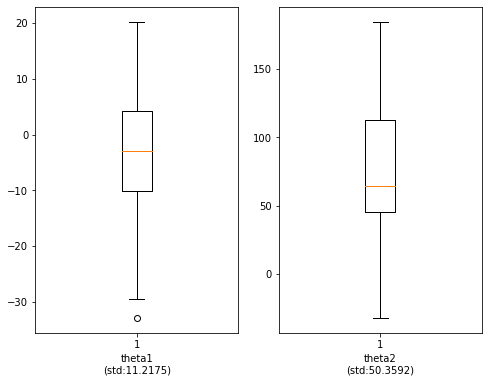

In [20]:
grads_enko = enko_gradient_sample(100, 16, None, 0., 0.1, 0.1, 1.0, seed=0)
name_list = ["theta1", "theta2"]#"theta w/o F", "theta2 w/ F", "theta2 w/o F", "grad_Cat2", "log_ZSMC"]

fig, ax = plt.subplots(1,len(grads_enko),figsize=(8,6))
for i, grad in enumerate(grads_enko):
    print(grad.std())
    ax[i].boxplot(grad)
    ax[i].set_xlabel("{}\n(std:{:.4f})".format(name_list[i], grad.std()))
fig.set_facecolor("w")

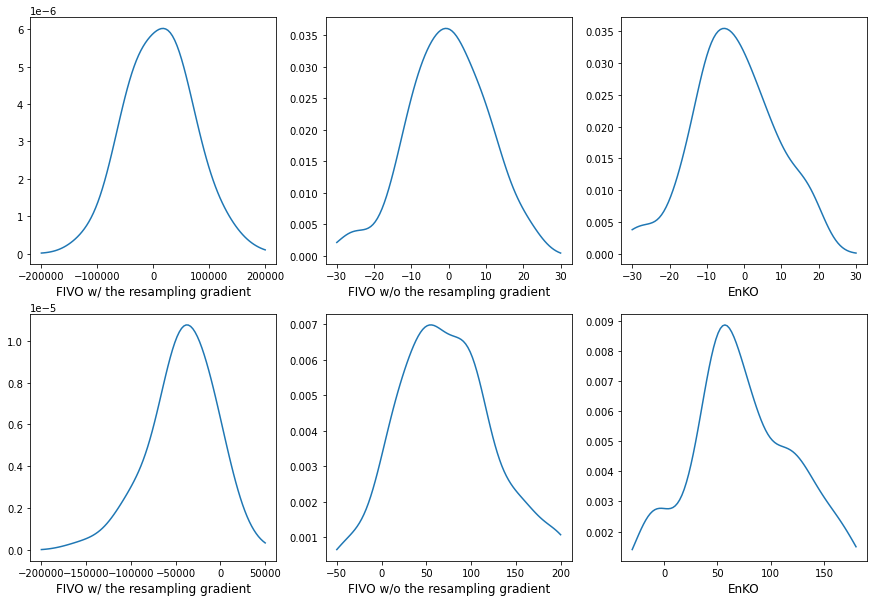

In [29]:
from sklearn.neighbors import KernelDensity
fs = 12
fig, ax = plt.subplots(2,3,figsize=(15,10))

plot_range = np.linspace(-200000,200000,100)[:,None]
log_dens = KernelDensity(kernel='gaussian', bandwidth=30000).fit(grads_fivo[0][:,None]).score_samples(plot_range)
ax[0,0].plot(plot_range[:,0], np.exp(log_dens))
ax[0,0].set_xlabel("FIVO w/ the resampling gradient", fontsize=fs)

plot_range = np.linspace(-30,30,100)[:,None]
log_dens = KernelDensity(kernel='gaussian', bandwidth=4).fit(grads_fivo[1][:,None]).score_samples(plot_range)
ax[0,1].plot(plot_range[:,0], np.exp(log_dens))
ax[0,1].set_xlabel("FIVO w/o the resampling gradient", fontsize=fs)

plot_range = np.linspace(-30,30,100)[:,None]
log_dens = KernelDensity(kernel='gaussian', bandwidth=4).fit(grads_enko[0][:,None]).score_samples(plot_range)
ax[0,2].plot(plot_range[:,0], np.exp(log_dens))
ax[0,2].set_xlabel("EnKO", fontsize=fs)

plot_range = np.linspace(-200000,50000,100)[:,None]
log_dens = KernelDensity(kernel='gaussian', bandwidth=20000).fit(grads_fivo[2][:,None]).score_samples(plot_range)
ax[1,0].plot(plot_range[:,0], np.exp(log_dens))
ax[1,0].set_xlabel("FIVO w/ the resampling gradient", fontsize=fs)

plot_range = np.linspace(-50,200,100)[:,None]
log_dens = KernelDensity(kernel='gaussian', bandwidth=18).fit(grads_fivo[3][:,None]).score_samples(plot_range)
ax[1,1].plot(plot_range[:,0], np.exp(log_dens))
ax[1,1].set_xlabel("FIVO w/o the resampling gradient", fontsize=fs)

plot_range = np.linspace(-30,180,100)[:,None]
log_dens = KernelDensity(kernel='gaussian', bandwidth=15).fit(grads_enko[1][:,None]).score_samples(plot_range)
ax[1,2].plot(plot_range[:,0], np.exp(log_dens))
ax[1,2].set_xlabel("EnKO", fontsize=fs)

fig.savefig("fig/kde_gradient.pdf", bbox_inches="tight")

In [31]:
for grad in grads_fivo:
    print(grad.std())

for grad in grads_enko:
    print(grad.std())

57075.78904088648
10.39228676987663
34723.404878851325
54.055354694767196
11.217522216005761
50.35918745196406
